In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import stats
from sklearn.ensemble import IsolationForest,RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge,ElasticNet,LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures

In [2]:
df = pd.read_csv('futuristic_city_traffic.csv')

In [3]:
df.head()

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density
0,SolarisVille,Drone,Snowy,Stable,Sunday,20,29.4268,0,0,14.7134,0.5241
1,AquaCity,Flying Car,Solar Flare,Recession,Wednesday,2,118.8000,0,0,143.5682,0.3208
2,Neuroburg,Autonomous Vehicle,Solar Flare,Recession,Wednesday,16,100.3904,0,0,91.2640,0.0415
3,Ecoopolis,Drone,Clear,Booming,Thursday,8,76.8000,1,0,46.0753,0.1811
4,AquaCity,Autonomous Vehicle,Solar Flare,Stable,Saturday,16,45.2176,0,0,40.1934,0.4544


In [4]:
df.isna().sum()

City                     0
Vehicle Type             0
Weather                  0
Economic Condition       0
Day Of Week              0
Hour Of Day              0
Speed                    0
Is Peak Hour             0
Random Event Occurred    0
Energy Consumption       0
Traffic Density          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   City                   1048575 non-null  object 
 1   Vehicle Type           1048575 non-null  object 
 2   Weather                1048575 non-null  object 
 3   Economic Condition     1048575 non-null  object 
 4   Day Of Week            1048575 non-null  object 
 5   Hour Of Day            1048575 non-null  int64  
 6   Speed                  1048575 non-null  float64
 7   Is Peak Hour           1048575 non-null  int64  
 8   Random Event Occurred  1048575 non-null  int64  
 9   Energy Consumption     1048575 non-null  float64
 10  Traffic Density        1048575 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 88.0+ MB


In [6]:
numeric_data = df.select_dtypes(exclude ='object')
object_data = df.select_dtypes(include ='object')
ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore').set_output(transform='pandas')
object_data = ohe.fit_transform(object_data)

In [7]:
z_scores = stats.zscore(numeric_data)
threshold = 3
outliers_zscore = (abs(z_scores) > threshold).any(axis=1)
numeric_data = numeric_data[~outliers_zscore]

In [8]:
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)
numeric_data = numeric_data[~outliers]

In [9]:
final_df = pd.concat([numeric_data,object_data],axis=1)

In [10]:
final_df.dropna(inplace=True)

In [11]:
traffic_density = final_df['Traffic Density'].values.reshape(-1, 1)
contamination_threshold = final_df['Traffic Density'].quantile(0.75) + 0.05
clf = IsolationForest(contamination=contamination_threshold, random_state=42)
outliers = clf.fit_predict(traffic_density)
final_df.reset_index(drop=True, inplace=True)
outliers_indices = final_df.index[outliers == -1]

In [12]:
final_df.drop(outliers_indices,inplace =True)

In [63]:
sample_data =final_df.sample(frac=0.001,random_state=101)

In [64]:
len(sample_data)

468

In [65]:
X = sample_data.drop('Traffic Density',axis=1)
y= sample_data['Traffic Density']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train =  scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
ridge = Ridge()
param_grid = {
    'alpha':[0.1,0.5,1,10,100]}
grid = GridSearchCV(estimator=ridge,param_grid=param_grid,cv=5,n_jobs=-1)

In [67]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 10, 100]})

In [68]:
y_pred = grid.predict(X_test)

In [69]:
ridgeMAE = mean_absolute_error(y_test,y_pred)
ridgeMSE = mean_squared_error(y_test,y_pred)

In [70]:
ridgeMAE

0.03908646697078459

In [71]:
ridgeMSE

0.0026887037918210217

In [129]:
normal_model = LinearRegression(n_jobs=-1)

In [130]:
normal_model.fit(X_train,y_train)

LinearRegression(n_jobs=-1)

In [132]:
y_pred_linear = normal_model.predict(X_test)

In [133]:
linear_MAE = mean_absolute_error(y_test,y_pred_linear)
linear_MSE = mean_squared_error(y_test,y_pred_linear)

In [72]:
elastico = ElasticNet()
param_grid = {
    'alpha':[0.1,0.5,1,10,100],
    'l1_ratio':[0.01,0.1,0.5,0.99,1],
    'warm_start': [False,True],
    'positive' : [False,True]
}
elasticgrid = GridSearchCV(estimator=elastico,param_grid=param_grid,n_jobs=-1,scoring='neg_mean_squared_error',cv=10)
elasticgrid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 10, 100],
                         'l1_ratio': [0.01, 0.1, 0.5, 0.99, 1],
                         'positive': [False, True],
                         'warm_start': [False, True]},
             scoring='neg_mean_squared_error')

In [73]:
y_pred_elastic = elasticgrid.predict(X_test)

In [74]:
elasticMAE = mean_absolute_error(y_test,y_pred_elastic)
elasticMSE = mean_squared_error(y_test,y_pred_elastic)

In [75]:
elasticMAE

0.039157388850406545

In [76]:
elasticMSE

0.0026136536947352087

In [77]:
rfr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
randomforestgrid = GridSearchCV(estimator=rfr,param_grid=random_grid,cv=3,n_jobs=-1,scoring='neg_mean_squared_error')
randomforestgrid.fit(X_train,y_train)

In [78]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 5, 7], 
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
grid_searchxgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)
grid_searchxgb.fit(X_train,y_train)

In [79]:
from lightgbm import LGBMRegressor
lgb_model = LGBMRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [20, 30, 50],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

grid_searchlgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)
grid_searchlgb.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 374, number of used features: 25
[LightGBM] [Info] Start training from score 0.169917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [80]:
y_pred_rfr = randomforestgrid.predict(X_test)
rfcMAE = mean_absolute_error(y_test,y_pred_rfr)
rfcMSE = mean_squared_error(y_test,y_pred_rfr)

In [81]:
y_pred_xgb = grid_searchxgb.predict(X_test)
xgbMAE = mean_absolute_error(y_test,y_pred_xgb)
xgbMSE = mean_squared_error(y_test,y_pred_xgb)

In [82]:
y_pred_lgb= grid_searchlgb.predict(X_test)
lgbMAE = mean_absolute_error(y_test,y_pred_lgb)
lgbMSE = mean_squared_error(y_test,y_pred_lgb)

In [83]:
rfcMAE

0.0401366010638298

In [84]:
rfcMSE

0.0026330356488164916

In [85]:
xgbMAE

0.038898528146363326

In [86]:
xgbMSE

0.002585955586745371

In [87]:
lgbMAE

0.03788322348377739

In [88]:
lgbMSE

0.0024509608360991386

In [156]:
mean_absolute_errors = [ridgeMAE,elasticMAE,rfcMAE,xgbMAE,lgbMAE,linear_MAE]

In [157]:
mean_absolute_errors

[0.03908646697078459,
 0.039157388850406545,
 0.0401366010638298,
 0.038898528146363326,
 0.03788322348377739,
 0.039931505887993726]

In [158]:
mean_squared_errors = [ridgeMSE,elasticMSE,rfcMSE,xgbMSE,lgbMSE,linear_MSE]

In [159]:
models= ['Ridge Regression','Elastic Net Regression','RandomForestRegressor','XGBRegressor','LGBMRegressor','LinearRegression']

In [160]:
metrics = pd.DataFrame({
    'models':models,
    'Mean Absolute Error':mean_absolute_errors,
    'Mean Squared Error':mean_squared_errors
})

Text(0.5, 1.0, 'Mean Squared Error on every model')

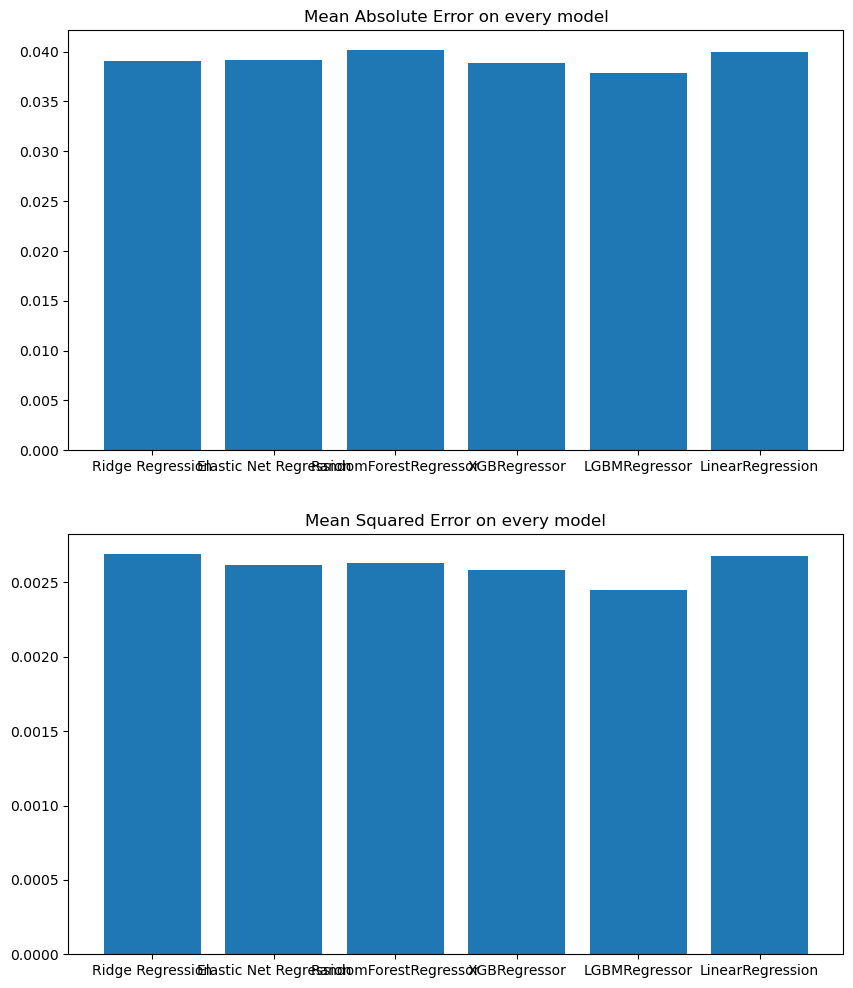

In [161]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs[0].bar(data=metrics,x=metrics['models'],height=metrics['Mean Absolute Error'])
axs[0].set_title(label='Mean Absolute Error on every model')
axs[0].set_xticks(ticks=metrics.index)
axs[1].bar(data=metrics,x=metrics['models'],height=metrics['Mean Squared Error'])
axs[1].set_xticks(ticks=metrics.index)
axs[1].set_title(label='Mean Squared Error on every model')

In [111]:
best_estimators = {
    'Ridge':[grid.best_estimator_],
    'ElasticNet':[elasticgrid.best_estimator_],
    'RandomForestRegressor':[randomforestgrid.best_estimator_],
    'XGBRegressor':[grid_searchxgb.best_estimator_],
    'LGBMRegressor':[grid_searchlgb.best_estimator_],
}

In [113]:
best_estimators.get('Ridge')

[Ridge(alpha=10)]

In [114]:
best_estimators.get('ElasticNet')

[ElasticNet(alpha=0.1, l1_ratio=0.01)]

In [118]:
best_estimators.get('RandomForestRegressor')

[RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200)]

In [119]:
best_estimators.get('XGBRegressor')

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)]

In [120]:
best_estimators.get('LGBMRegressor')

[LGBMRegressor(colsample_bytree=0.9, max_depth=7, min_child_samples=30,
               n_estimators=200, num_leaves=15, reg_lambda=0.1, subsample=0.8)]